In [1]:
from line_solver import *
import numpy as np
GlobalConstants.set_verbose(VerboseLevel.STD)

In [2]:
# CDF Response Time Analysis Example 4
# Closed network with two classes and different service distributions

model = Network('model')

# Create closed queueing network
node = [None] * 2  # using 0-based indexing
node[0] = Delay(model, 'Delay')
node[1] = Queue(model, 'Queue1', SchedStrategy.PS)

# Two closed classes with different populations
jobclass = [None] * 2  # using 0-based indexing
jobclass[0] = ClosedClass(model, 'Class1', 1, node[0], 0)  # 1 job of Class1
jobclass[1] = ClosedClass(model, 'Class2', 3, node[0], 0)  # 3 jobs of Class2

# Service processes at Delay node
node[0].set_service(jobclass[0], Exp.fit_mean(1.0))           # Class1: Exp with mean=1.0
node[0].set_service(jobclass[1], Erlang.fit_mean_and_order(4.0, 2))  # Class2: Erlang with mean=4.0, order=2

# Service processes at Queue1 node  
node[1].set_service(jobclass[0], Exp.fit_mean(2.0))           # Class1: Exp with mean=2.0
node[1].set_service(jobclass[1], HyperExp.fit_mean_and_scv(5.0, 30.0))  # Class2: HyperExp with mean=5.0, SCV=30.0

# Routing matrix - independent circulation for each class
P = model.init_routing_matrix()

# Class 1 circular routing
P.set(jobclass[0], jobclass[0], node[0], node[1], 1.0)
P.set(jobclass[0], jobclass[0], node[1], node[0], 1.0)

# Class 2 circular routing 
P.set(jobclass[1], jobclass[1], node[0], node[1], 1.0)
P.set(jobclass[1], jobclass[1], node[1], node[0], 1.0)

model.link(P)

In [3]:
# Solve with JMT solver - aligned with JAR test scenario
jmtoptions = JMT.default_options()
jmtoptions.samples = int(100000)  # Aligned with JAR test: samples=100000  
jmtoptions.seed = 23000  # Aligned with JAR test: seed=23000
# Note: JAR test also uses keep=true, but Python wrapper may not have this option
RDsim = JMT(model, jmtoptions).get_tran_cdf_respt()  # Using getTranCdfRespT like JAR test

JMT Model: /tmp/workspace/jsim/518667119948119864/jmodel.jsim
JMT Model: /tmp/workspace/jsim/8723006643392542885/jmodel.jsim


In [4]:
# Solve with Fluid solver - aligned with JAR test scenario (default options)
RDfluid = FLD(model).cdf_respt()  # Using default options like JAR test

INFO: Added 20 refined points between t=0.000000 and t=0.194537
INFO: Added 20 refined points between t=0.000000 and t=0.194537
INFO: Added 20 refined points between t=0.000000 and t=0.194537
INFO: Added 20 refined points between t=0.000000 and t=0.194537


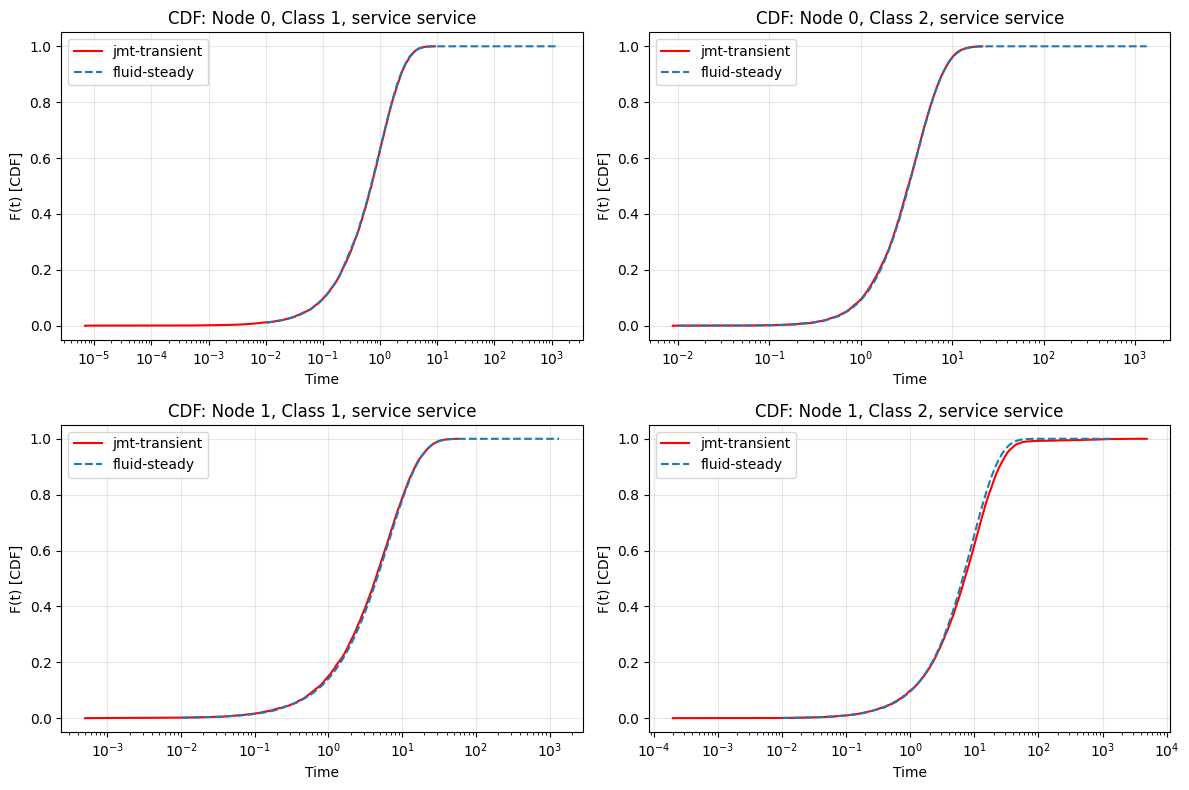

AvgRespTfromCDFfluid =
[[1.081882   4.11072405]
 [6.68609968 9.46098049]]
AvgRespTfromCDFsim =
[[ 1.00806267  3.97293772]
 [ 6.43518878 15.72156765]]


In [5]:
# Plotting and comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(model.get_number_of_stations(), 2, figsize=(12, 8))

for i in range(model.get_number_of_stations()):
    # Class 1 plot - Plot CDF (not complementary CDF)
    if RDsim[i][0] is not None and RDfluid[i][0] is not None:
        # Data format is [CDF_value, time]
        # No need for offset - (0,0) point has been removed
        time_sim = RDsim[i][0][:, 1]    # Time values
        cdf_sim = RDsim[i][0][:, 0]     # CDF values
        time_fluid = RDfluid[i][0][:, 1]  # Time values
        cdf_fluid = RDfluid[i][0][:, 0]   # CDF values
        
        axes[i, 0].semilogx(time_sim, cdf_sim, 'r', label='jmt-transient')
        axes[i, 0].semilogx(time_fluid, cdf_fluid, '--', label='fluid-steady')
        axes[i, 0].legend(loc='best')
        axes[i, 0].set_ylabel('F(t) [CDF]')
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Get service process name for title
        service_name = node[i].serviceProcess[0].name if hasattr(node[i], 'serviceProcess') else 'service'
        axes[i, 0].set_title(f'CDF: Node {i}, Class 1, {service_name} service')
    
    # Class 2 plot - Plot CDF (not complementary CDF)
    if RDsim[i][1] is not None and RDfluid[i][1] is not None:
        # Data format is [CDF_value, time]
        # No need for offset - (0,0) point has been removed
        time_sim = RDsim[i][1][:, 1]    # Time values
        cdf_sim = RDsim[i][1][:, 0]     # CDF values
        time_fluid = RDfluid[i][1][:, 1]  # Time values
        cdf_fluid = RDfluid[i][1][:, 0]   # CDF values
        
        axes[i, 1].semilogx(time_sim, cdf_sim, 'r', label='jmt-transient')
        axes[i, 1].semilogx(time_fluid, cdf_fluid, '--', label='fluid-steady')
        axes[i, 1].legend(loc='best')
        axes[i, 1].set_ylabel('F(t) [CDF]')
        axes[i, 1].set_xlabel('Time')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Get service process name for title
        service_name = node[i].serviceProcess[1].name if hasattr(node[i], 'serviceProcess') else 'service'
        axes[i, 1].set_title(f'CDF: Node {i}, Class 2, {service_name} service')

plt.tight_layout()
plt.show()

# Calculate average response times from CDFs
# Data format is [CDF_value, time]
AvgRespTfromCDFfluid = np.zeros((model.get_number_of_stations(), model.get_number_of_classes()))
AvgRespTfromCDFsim = np.zeros((model.get_number_of_stations(), model.get_number_of_classes()))

for i in range(model.get_number_of_stations()):
    for c in range(model.get_number_of_classes()):
        # From Fluid CDF - format: [CDF_value, time]
        if RDfluid[i][c] is not None and len(RDfluid[i][c]) > 1:
            diffs = np.diff(RDfluid[i][c][:, 0])  # diff of CDF values (column 0)
            values = RDfluid[i][c][1:, 1]         # time values (column 1)
            AvgRespTfromCDFfluid[i, c] = np.sum(diffs * values)
        
        # From Simulation CDF - format: [CDF_value, time]
        if RDsim[i][c] is not None and len(RDsim[i][c]) > 1:
            diffs = np.diff(RDsim[i][c][:, 0])    # diff of CDF values (column 0)
            values = RDsim[i][c][1:, 1]           # time values (column 1)
            AvgRespTfromCDFsim[i, c] = np.sum(diffs * values)

print('AvgRespTfromCDFfluid =')
print(AvgRespTfromCDFfluid)
print('AvgRespTfromCDFsim =')
print(AvgRespTfromCDFsim)